# Cork tracking with trackpy

### 15 April 2019

This notebook outlines the processing pipeline for video footage of painted cork floats in the Dalhousie Aquatron pool tank in early April 2019.

Much of this notebook is adapted from the trackpy walkthrough found at [http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html](http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html).

In [5]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import scipy.io
import glob
import os
import errno

# packages for image manipulation and tracking (will need to be installed on local machine)
import pims
import trackpy as tp

# I use the opencv computer vision library for image analyses. 
# The operations used in this script can also be done using only numpy (with a bit more work).
import cv2 as cv

Populate a list of the video frame filenames using `glob`. I decimate video into images using `ffmpeg`. Read about it [here](https://ffmpeg.org/).

Example code to extract all frames at highst quality:`ffmpeg -i pi71_1554994358.h264 -qscale:v 2 C:\Projects\Aquatron2019_April\data\interim\April11\images\pi71_1554994358_%05d.jpg -hide_banner`

In [6]:
homechar = "C:\\"

# day = "April10"
day = "April11"

# vid = "pi71_1554994358" # ?
# vid = "pi71_1554994823" # 70% flow?
# vid = "pi71_1554995860" # 70?

# 100%
vid = "pi71_1554997692"

# or wherever your images are
imgdir = os.path.join(homechar, "Projects", "ptv-aquatron2019", "data", "interim", \
    day, "images", vid, "select")

# or wherever you want the segemented images saved
savedir = os.path.join(imgdir, "binary")

if not os.path.exists(savedir):
    try:
        os.makedirs(savedir)
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

imgs = sorted(glob.glob(os.path.join(imgdir, '*.jpg')))


Use the following block of code to tune the segementation settings. When you find something that works well, apply the same settings in the function `segmentImage` that follows.

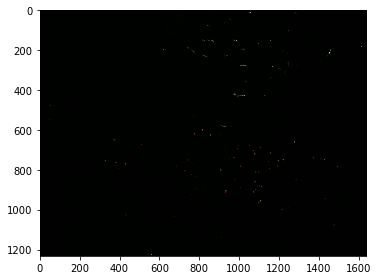

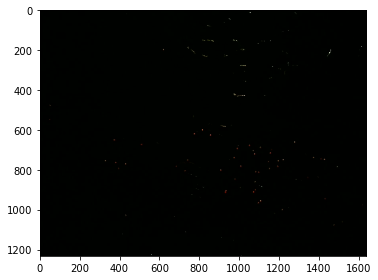

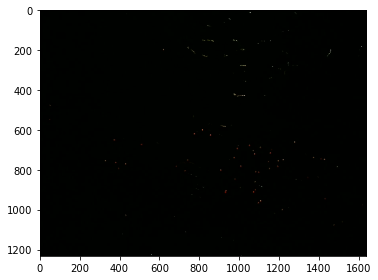

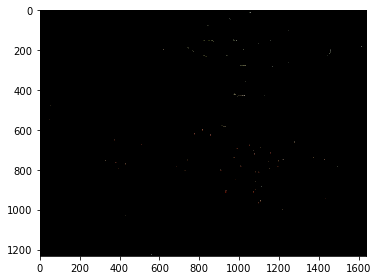

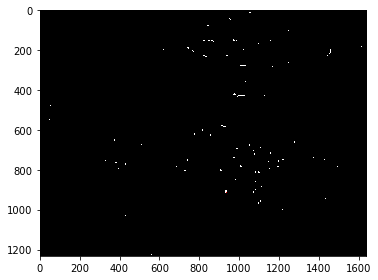

In [7]:
im = plt.imread(imgs[199])

plt.figure().clf()
plt.imshow(im)
plt.tight_layout()
plt.draw()
plt.show()

 # gaussian filter:
im_blur = cv.GaussianBlur(im,(5,5),0)

plt.figure().clf()
plt.imshow(im_blur)
plt.tight_layout()
plt.draw()
plt.show()

r, g, b = cv.split(im_blur)

# mask white
minclr = 130
is_blu = cv.inRange(b, minclr, 255)
is_grn = cv.inRange(g, minclr, 255)
is_red = cv.inRange(r, minclr, 255)
wht_mask = np.logical_and(is_red, is_grn)
wht_mask = np.logical_and(wht_mask, is_blu)

nowhite = im_blur.copy()
nowhite[wht_mask!=0] = (0,0,0)

plt.figure(2)
plt.imshow(nowhite)
plt.tight_layout()


is_blu = cv.inRange(b, 0, 255)
is_grn = cv.inRange(g, 0, 255)
is_red = cv.inRange(r, 0, 25)
gb_mask = np.logical_and(is_red, is_grn)
gb_mask = np.logical_and(gb_mask, is_blu)

nogb = im_blur.copy()
nogb[gb_mask!=0] = (0,0,0)

nogbw = nogb.copy()
nogbw[wht_mask!=0] = (0,0,0)

plt.figure(3)
plt.imshow(nogbw)
plt.tight_layout()

nogbw[nogbw > 0] = 255

plt.figure(4)
plt.imshow(nogbw)
plt.tight_layout()


Here's a function that segments out the red-topped corks:

In [8]:
def segmentImage(file):
    
    im = plt.imread(file)
    
    # gaussian filter:
    im_blur = cv.GaussianBlur(im,(5,5),0)

    # split colour channels
    r, g, b = cv.split(im_blur)

    # mask white
    minclr = 130
    is_blu = cv.inRange(b, minclr, 255)
    is_grn = cv.inRange(g, minclr, 255)
    is_red = cv.inRange(r, minclr, 255)
    wht_mask = np.logical_and(is_red, is_grn)
    wht_mask = np.logical_and(wht_mask, is_blu)

    # grn/blu mask
    is_blu = cv.inRange(b, 0, 255)
    is_grn = cv.inRange(g, 0, 255)
    is_red = cv.inRange(r, 0, 25)
    gb_mask = np.logical_and(is_red, is_grn)
    gb_mask = np.logical_and(gb_mask, is_blu)
    
    # apply masks
    nogb = im_blur.copy()
    nogb[gb_mask!=0] = (0,0,0)
    nogbw = nogb.copy()
    nogbw[wht_mask!=0] = (0,0,0)

    # "turn up" all non-zero values
    nogbw[nogbw > 0] = 255
    
    return nogbw

Apply the segmentation to all the images. This takes a while (10s of minutes).

In [9]:
for file in imgs:
    
    nogbw = segmentImage(file)

    fn = file[-25:-4] + '.jpg'
    plt.imsave(os.path.join(savedir, fn), nogbw)

The rest of this notebook is adapted from the trackpy walkthrough found [here](http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html).

Read in the newly segemented image sequence. The images should be preprocessed so the features to be tracked are light or dark relative to the background. Some preprocessing can be done within the trackpy environment, though I haven't really played around with this. The trackpy package is also capable of reading raw video, but this requires a bit more effort, and some extra packages. 

In [10]:
# frames = pims.ImageSequence(r'C:\Projects\Aquatron2019_April\data\interim\April11\images\select\binary\gaussian_blur\pi71*.jpg', as_grey=True)
frames = pims.ImageSequence(os.path.join(savedir, 'pi71*.jpg'), as_grey=True)

Sample image:

In [11]:
testframe = frames[154]

Try locating features in a single image with trackpy's `locate()` function. The only required inputs are an image file, and a feature pixel diameter estimate (must be odd). If the features to be tracked are light/white, set invert=True. The trackpy tutorial suggests erring on the large side when estimating feature diameter. Try `tp.locate?` to see other optional inputs.

In [12]:
d_cork = 11 # estimated diameter of tracked features
f0 = tp.locate(testframe, d_cork, invert=False)

C:\Users\Owner\Anaconda3\envs\aquatron_ptv\lib\site-packages\trackpy\refine\center_of_mass.py:233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neighborhood = mask*image[rect]
C:\Users\Owner\Anaconda3\envs\aquatron_ptv\lib\site-packages\trackpy\refine\center_of_mass.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_neighborhood = mask*raw_image[rect]


Trackpy produces a pandas dataframe that contains the data. Use the `head()` function to take a truncated look.

In [13]:
f0.head() # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,20.905209,622.922635,4020.872956,3.221047,0.023515,123.197946,8922.0,0.000071,154
1,45.129093,1021.852666,4938.697652,2.903419,0.417241,165.547240,11719.0,0.000054,154
3,49.249632,826.898970,1570.003822,1.752039,0.258761,137.057715,2333.0,0.000271,154
5,53.806838,1314.502991,1801.769957,1.661916,0.226115,171.707137,2568.0,0.000246,154
6,99.285047,839.763178,4119.431313,2.140050,0.129956,188.646855,7645.0,0.000083,154


Use the `annotate()` function to overlay the identified features on the image. It probably won't look great the first time around. 

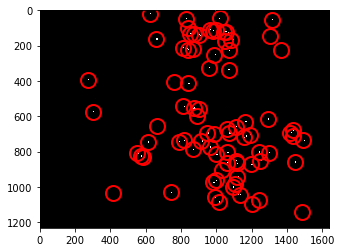

In [14]:
plt.figure()  # make a new figure
tp.annotate(f0, testframe)

Plot a histogram of the "mass" of the features to be tracked. The mass is a measure of the total pixel intensity associated with each feature. Since I've already segmented out the corks into binary structures, the mass checking step is not all that useful. If I hadn't done this preprocessing step, the corks might be expected to have a characteristic mass, with a distribution that would be identifiable in the histogram. One could then define a lower mass cutoff to eliminate features that aren't of interest. 

[Text(0, 0.5, 'count'), Text(0.5, 0, 'mass')]

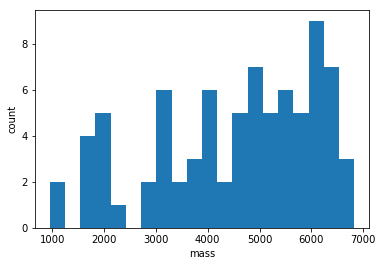

In [15]:
fig, ax = plt.subplots()
ax.hist(f0['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

Here, I pick a cutoff of 0, since I'm interested in all the information that remains in the image. 

In [ ]:
f0 = tp.locate(testframe, d_cork, invert=False, minmass=0)

Try overlaying data on image again. If any cutoff has been applied, the location estimates should be improved.

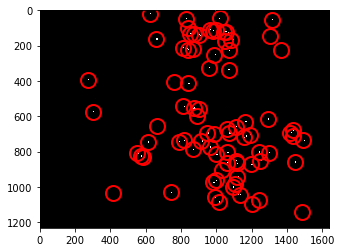

In [ ]:
plt.figure()
tp.annotate(f0, testframe)

To check that the diameter of the kernel used is not too small, trackpy includes a plotting function for evaluating subpixel bias. If the kernel is too small, the x- and y-coordinates will be predominantly integer-valued. Look for a uniform (flat) distribution of decimal values in the x- and y-coordinate histograms. If the histograms display a "dip" in the middle, try using a larger value for feature diameter.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D985CC860>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

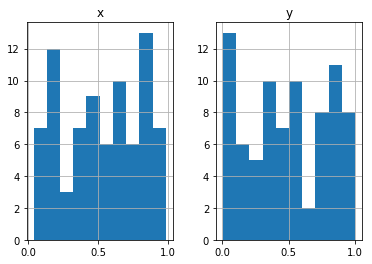

In [ ]:
plt.figure()
tp.subpx_bias(f0)

Once satisfied with the quality of feature tracking, process the entire batch of images using the settings that were tuned earlier. This step might take a while if processing many images.

In [ ]:
# f = tp.batch(frames[150:300], d_cork, minmass=0, invert=False) # process subset
f = tp.batch(frames, d_cork, minmass=0, invert=False)

Frame 601: 110 features


The `link_df` function takes a dataframe of feature locations, and returns a new dataframe with trajectory information. The only other required input is an integer pixel value defining how far a feature is allowed to travel between time steps. The `memory` option defines how many time steps a feature can be out of sight before being considered a different particle after reappearing.

In [ ]:
t = tp.link_df(f, 9, memory=5)

For this image set, the `filter_stubs` function is the most important noise-reducing step. It filters out trajectories that persist for fewer than the defined number of time steps (in this case, 50). This is effective for removing any remaining artefacts of light reflection from the water's surface.

In [ ]:
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Filtering by appearance, e.g. in size-mass space, is also possible. This is generally a trial and error process. See the trackpy walkthrough for more discussion of appearance filtering. 

In [ ]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean())  # convenience function -- just plots size vs. mass

If all the desired filtering of trajectory data is complete, we can plot the trajectories.

In [ ]:
plt.figure()
tp.plot_traj(t1, colorby='particle')

In [ ]:
t1.head()

Export dataframe as both python and matlab readable files.

In [ ]:
scipy.io.savemat(os.path.join(homechar, "Projects", "Aquatron2019_April", "data", "processed", vid + ".mat"), \
                 {'cork_traj':t1.to_dict("list")})
t1.to_pickle(os.path.join(homechar, "Projects", "Aquatron2019_April", "data", "processed", vid + ".pkl"))  # where to save it, usually as a .pkl